We have extracted six files as follows

- exp_coords_NPs.txt

- exp_element_connectivity.txt

- sim_coords_NPs.txt

- sim_element_shell_thickness.txt

- sim_initial_stress_shell.txt

- sim_initial_strain_shell.txt

num nodes in all sim files are equal. Num nodes in exp coords is not the same as in sim but its cad model is roughly same as sim.

this is because sim has load BC (sheet metal forming), not disp BC, and thus deformed result is not same as intended CAD

Task 2: prepare the new .stl file so that LS-Dyna accepts for restart analysis with the interpolated stress and strain on the exp CAD model. In short replace the sim mesh with exp mesh and replace stress and strain as the interpolated versions. 

### Step 1: Load the matrices from the .txt file

In [1]:
import numpy as np

def load_exp_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            # Make sure line is long enough
            line = line.rstrip("\n")
            if len(line) < 56:
                continue

            nid = int(line[0:8])
            x = float(line[8:24])
            y = float(line[24:40])
            z = float(line[40:56])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            nid = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)



# 5) EXP shell element connectivity  (*ELEMENT_SHELL without zeros)
def load_exp_shell_elements(path):
    """
    Read experimental *ELEMENT_SHELL file like:

    *ELEMENT_SHELL
       40741       2   43971   43972   43902   43901
       40742       2   43972   43973   43903   43902
       ...

    Returns:
        eids : (Ne,) int array
        pids : (Ne,) int array
        conn : (Ne, 4) int array
    """
    eids = []
    pids = []
    conn = []

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 6:
                # eid, pid, n1..n4
                continue

            eid = int(parts[0])
            pid = int(parts[1])
            node_ids = [int(p) for p in parts[2:6]]

            eids.append(eid)
            pids.append(pid)
            conn.append(node_ids)

    eids = np.array(eids, dtype=int)
    pids = np.array(pids, dtype=int)
    conn = np.array(conn, dtype=int)
    return eids, pids, conn


import numpy as np

def load_element_shell_thickness(path, parts=None):
    """
    Parse LS-DYNA *ELEMENT_SHELL_THICKNESS blocks.

    Supports:
      - files containing the *ELEMENT_SHELL_THICKNESS keyword header, or
      - "data-only" files made of repeated (conn line + thickness line(s)) records.

    Parameters
    ----------
    path : str
        File path.
    parts : list[int] or None
        If provided, returns only those part IDs (PIDs), in the given order,
        as lists of arrays: [eids_per_part], [pids_per_part], [conn_per_part], [thick_per_part].
        If None, returns flat arrays for all elements.

    Returns
    -------
    If parts is None:
        eids  : (Ne,) int
        pids  : (Ne,) int
        conn  : (Ne, nen) int
        thick : (Ne, nen) float
    If parts is list:
        eids_list  : list of (Ne_i,) int arrays
        pids_list  : list of (Ne_i,) int arrays (all entries = parts[i])
        conn_list  : list of (Ne_i, nen) int arrays
        thick_list : list of (Ne_i, nen) float arrays
    """

    eids_all, pids_all, conn_all, thick_all = [], [], [], []

    in_block = False
    expecting_conn = True

    # Pending record buffers
    pending_eid = None
    pending_pid = None
    pending_conn = None
    pending_nen = None
    pending_thicks = []

    def is_skip_line(s):
        return (not s) or s.startswith("$")

    with open(path, "r") as f:
        for raw in f:
            s = raw.strip()
            if is_skip_line(s):
                continue

            # Keyword lines
            if s.startswith("*"):
                if s.upper().startswith("*ELEMENT_SHELL_THICKNESS"):
                    in_block = True
                    expecting_conn = True
                    pending_eid = pending_pid = None
                    pending_conn = None
                    pending_nen = None
                    pending_thicks = []
                else:
                    in_block = False
                continue

            # If no keyword header, treat it as data-only: parse anyway
            parts_split = s.split()

            if expecting_conn:
                # Expect: eid pid n1 n2 n3 n4 [n5..] with possible zeros
                if len(parts_split) < 6:
                    continue

                pending_eid = int(parts_split[0])
                pending_pid = int(parts_split[1])

                node_ids = [int(x) for x in parts_split[2:] if int(x) != 0]
                pending_nen = len(node_ids)
                if pending_nen < 3:
                    # invalid shell
                    pending_eid = pending_pid = None
                    pending_conn = None
                    pending_nen = None
                    pending_thicks = []
                    continue

                pending_conn = node_ids
                pending_thicks = []
                expecting_conn = False

            else:
                # Thickness values may span multiple lines; collect until nen values
                for x in parts_split:
                    pending_thicks.append(float(x))

                if len(pending_thicks) >= pending_nen:
                    th = pending_thicks[:pending_nen]

                    eids_all.append(pending_eid)
                    pids_all.append(pending_pid)
                    conn_all.append(pending_conn)
                    thick_all.append(th)

                    # reset
                    expecting_conn = True
                    pending_eid = pending_pid = None
                    pending_conn = None
                    pending_nen = None
                    pending_thicks = []

    # Convert to arrays
    eids_all = np.asarray(eids_all, dtype=int)
    pids_all = np.asarray(pids_all, dtype=int)
    conn_all = np.asarray(conn_all, dtype=int)
    thick_all = np.asarray(thick_all, dtype=float)

    if parts is None:
        return eids_all, pids_all, conn_all, thick_all

    # Return per requested part, in given order
    eids_list, pids_list, conn_list, thick_list = [], [], [], []
    parts = [int(p) for p in parts]

    for pid in parts:
        mask = (pids_all == pid)
        eids_list.append(eids_all[mask])
        pids_list.append(pids_all[mask])
        conn_list.append(conn_all[mask])
        thick_list.append(thick_all[mask])

    return eids_list, pids_list, conn_list, thick_list

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            nid = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)

print()
exp_ids, exp_coords = load_exp_nodes("exp_coords_NPs.txt")
print("Shape of exp_ids:", exp_ids.shape)
print("Shape of exp_coords:", exp_coords.shape)
print(exp_ids[:5])
print(exp_coords[:5])

print()
sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")
print("Shape of sim_ids:", sim_ids.shape)
print("Shape of sim_coords:", sim_coords.shape)
print(sim_ids[:5])
print(sim_coords[:5])

print()
exp_eids, exp_pids, exp_conn = load_exp_shell_elements("exp_element_connectivity.txt")
print("Shape of exp_eids:", exp_eids.shape)
print("Shape of exp_pids:", exp_pids.shape)
print("Shape of exp_conn:", exp_conn.shape)
print(exp_eids[:5])
print(exp_pids[:5])
print(exp_conn[:5])

# =========================
# Extract sheet (PID=2) and ball (PID=3) in this order
# =========================
sim_eids_parts, sim_pids_parts, sim_conn_parts, sim_thick_corner_parts = load_element_shell_thickness(
    "sim_element_shell_thickness.txt",
    parts=[2, 3]
)

sim_eids_sheet = sim_eids_parts[0]
sim_pids_sheet = sim_pids_parts[0]
sim_conn_sheet = sim_conn_parts[0]
sim_thick_corner_sheet = sim_thick_corner_parts[0]

sim_eids_ball = sim_eids_parts[1]
sim_pids_ball = sim_pids_parts[1]
sim_conn_ball = sim_conn_parts[1]
sim_thick_corner_ball = sim_thick_corner_parts[1]

print()
print("SHEET (PID=2):")
print("  eids:", sim_eids_sheet.shape)
print("  conn:", sim_conn_sheet.shape)
print("  thick:", sim_thick_corner_sheet.shape)
print("  first:", sim_eids_sheet[:1], sim_conn_sheet[:1], sim_thick_corner_sheet[:1])

print()
print("BALL (PID=3):")
print("  eids:", sim_eids_ball.shape)
print("  conn:", sim_conn_ball.shape)
print("  thick:", sim_thick_corner_ball.shape)
print("  first:", sim_eids_ball[:1], sim_conn_ball[:1], sim_thick_corner_ball[:1])

# -------------------------
# Load SIM nodes (all)
# -------------------------
sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")

# -------------------------
# Split into sheet/ball OUTSIDE the function using node sets from connectivity
# (Assumes you already loaded sim_conn_sheet and sim_conn_ball from thickness/connectivity)
# -------------------------
sheet_node_ids = np.unique(sim_conn_sheet.reshape(-1))
ball_node_ids  = np.unique(sim_conn_ball.reshape(-1))

sheet_node_set = set(map(int, sheet_node_ids))
ball_node_set  = set(map(int, ball_node_ids))

is_sheet = np.fromiter((int(n) in sheet_node_set for n in sim_ids), dtype=bool, count=sim_ids.size)
is_ball  = np.fromiter((int(n) in ball_node_set  for n in sim_ids), dtype=bool, count=sim_ids.size)

sim_ids_sheet = sim_ids[is_sheet]
sim_coords_sheet = sim_coords[is_sheet]

sim_ids_ball = sim_ids[is_ball]
sim_coords_ball = sim_coords[is_ball]

# print()

print("All SIM nodes:", sim_ids.shape[0])
print("Sheet nodes:", sim_ids_sheet.shape[0])
print("Ball nodes :", sim_ids_ball.shape[0])

# Optional sanity checks
overlap = sheet_node_set.intersection(ball_node_set)
print("Shared nodes between sheet and ball:", len(overlap))
if len(overlap) > 0:
    print("Example shared node IDs:", list(overlap)[:10])



Shape of exp_ids: (8236,)
Shape of exp_coords: (8236, 3)
[1 2 3 4 5]
[[ 70.66840319 -68.00003755 -22.79932967]
 [ 69.24672329 -68.00003753 -23.78386867]
 [ 67.67323302 -68.00003752 -24.50123927]
 [ 70.66839424 -66.00003709 -22.79933808]
 [ 69.24671713 -66.00003699 -23.78387217]]

Shape of sim_ids: (8722,)
Shape of sim_coords: (8722, 3)
[43901 43902 43903 43904 43905]
[[-115.       -69.5122     0.     ]
 [-115.       -67.49735    0.     ]
 [-115.       -65.48251    0.     ]
 [-115.       -63.46766    0.     ]
 [-115.       -61.45281    0.     ]]

Shape of exp_eids: (7560,)
Shape of exp_pids: (7560,)
Shape of exp_conn: (7560, 4)
[1 2 3 4 5]
[1 1 1 1 1]
[[ 1  4  5  2]
 [ 2  5  6  3]
 [ 4  7  8  5]
 [ 5  8  9  6]
 [ 7 10 11  8]]

SHEET (PID=2):
  eids: (7935,)
  conn: (7935, 4)
  thick: (7935, 4)
  first: [40741] [[43971 43972 43902 43901]] [[1. 1. 1. 1.]]

BALL (PID=3):
  eids: (600,)
  conn: (600, 4)
  thick: (600, 4)
  first: [48676] [[52021 52032 52033 52022]] [[0. 0. 0. 0.]]
All SIM 

In [2]:
import numpy as np
from collections import defaultdict

# Uses ONLY the SHEET arrays:
#   sim_eids_sheet          (Ne, )
#   sim_conn_sheet          (Ne, 4)
#   sim_thick_corner_sheet  (Ne, 4)

def check_sheet_node_thickness_consistency(sim_eids_sheet, sim_conn_sheet, sim_thick_corner_sheet,
                                           tol=1e-12, max_report=25):
    """
    For the SHEET only:
    Verify that for each node ID, all thickness values assigned to that node
    across all connected elements are identical within tol.

    Prints summary and returns a list of inconsistent nodes (empty if none).
    """
    node_vals = defaultdict(list)  # nid -> list of thickness samples

    Ne, nen = sim_conn_sheet.shape
    for e in range(Ne):
        for a in range(nen):
            nid = int(sim_conn_sheet[e, a])
            t = float(sim_thick_corner_sheet[e, a])
            node_vals[nid].append(t)

    exceptions = []
    for nid, vals_list in node_vals.items():
        vals = np.asarray(vals_list, dtype=float)
        vmin = float(vals.min())
        vmax = float(vals.max())
        if abs(vmax - vmin) > tol:
            exceptions.append((nid, len(vals_list), vmin, vmax, vmax - vmin))

    print(f"Sheet-only check: {len(node_vals)} unique sheet nodes.")
    print(f"Inconsistent thickness nodes: {len(exceptions)} (tol={tol})")

    if len(exceptions) == 0:
        print("✅ No exceptions: all shared nodes have identical thickness within tolerance.")
        return []

    # report worst offenders
    exceptions.sort(key=lambda x: x[4], reverse=True)
    print(f"❌ Showing up to {max_report} worst inconsistencies:")
    for nid, occ, vmin, vmax, delta in exceptions[:max_report]:
        print(f"  nid={nid} occ={occ} t_min={vmin:.12e} t_max={vmax:.12e} delta={delta:.12e}")

    return exceptions


exceptions_sheet = check_sheet_node_thickness_consistency(
    sim_eids_sheet,
    sim_conn_sheet,
    sim_thick_corner_sheet,
    tol=1e-12,
    max_report=25
)


Sheet-only check: 8120 unique sheet nodes.
Inconsistent thickness nodes: 7140 (tol=1e-12)
❌ Showing up to 25 worst inconsistencies:
  nid=51529 occ=4 t_min=9.355062000000e-01 t_max=1.000000000000e+00 delta=6.449380000000e-02
  nid=51530 occ=2 t_min=9.355062000000e-01 t_max=1.000000000000e+00 delta=6.449380000000e-02
  nid=44391 occ=2 t_min=9.382856000000e-01 t_max=1.000000000000e+00 delta=6.171440000000e-02
  nid=44392 occ=4 t_min=9.382856000000e-01 t_max=1.000000000000e+00 delta=6.171440000000e-02
  nid=51461 occ=2 t_min=9.402748000000e-01 t_max=1.000000000000e+00 delta=5.972520000000e-02
  nid=51462 occ=4 t_min=9.402748000000e-01 t_max=1.000000000000e+00 delta=5.972520000000e-02
  nid=44459 occ=4 t_min=9.410035000000e-01 t_max=1.000000000000e+00 delta=5.899650000000e-02
  nid=44460 occ=2 t_min=9.410035000000e-01 t_max=1.000000000000e+00 delta=5.899650000000e-02
  nid=44393 occ=4 t_min=9.434897000000e-01 t_max=1.000000000000e+00 delta=5.651030000000e-02
  nid=51528 occ=4 t_min=9.48522

It seems that nodes shared between different elements also has varying thickness between those elements. Now we load the initial stress and strain

### Loading the sim_initial_strain_shell.txt and sim_initial_stress_shell.txt

In [3]:
import numpy as np

# ============================================================
# FIXED-WIDTH (10 chars) PARSERS
# ============================================================

def _parse_fixed10_fields(line, nvals):
    """
    Parse a line where each value occupies exactly 10 characters.
    Keeps leading spaces (important!). Pads right if line is short.
    """
    s = line.rstrip("\n")
    need = 10 * nvals
    if len(s) < need:
        s = s.ljust(need)

    out = np.empty(nvals, dtype=float)
    for i in range(nvals):
        chunk = s[i*10:(i+1)*10]
        out[i] = float(chunk)
    return out


def _parse_8_floats_fixed10(line):
    """
    Stress line: exactly 8 values (each 10 chars):
      zeta, sxx, syy, szz, sxy, syz, szx, eqplas
    """
    s = line.strip()
    if not s or s.startswith("$"):
        return None
    return _parse_fixed10_fields(line, nvals=8)


def _parse_6_floats_fixed10(line):
    """
    Strain line: exactly 6 values (each 10 chars):
      exx eyy ezz exy eyz ezx
    """
    s = line.strip()
    if not s or s.startswith("$"):
        return None
    return _parse_fixed10_fields(line, nvals=6)


# ============================================================
# STRESS LOADER (keeps your variable names)
# ============================================================

def load_initial_stress_shell(path):
    """
    Parse LS-DYNA *INITIAL_STRESS_SHELL with fixed-width 10-char fields.

    Returns ALL elements in the file:
      sim_stress_eids_all     : (Ne,) int
      sim_stress_nplane_all   : (Ne,) int
      sim_stress_nthick_all   : (Ne,) int
      sim_stress_nhisv_all    : (Ne,) int
      sim_stress_zeta_all     : (Ne, nthick) float
      sim_stress_stress6_all  : (Ne, nthick, 6) float  [sxx, syy, szz, sxy, syz, szx]
      sim_stress_eqplas_all   : (Ne, nthick) float
    """
    eids = []
    nplane_list = []
    nthick_list = []
    nhisv_list = []

    zeta_blocks = []
    stress6_blocks = []
    eqplas_blocks = []

    in_block = False

    def _skip(s):
        return (not s) or s.startswith("$")

    with open(path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        s = lines[i].strip()
        i += 1

        if _skip(s):
            continue

        if s.startswith("*"):
            if s.upper().startswith("*INITIAL_STRESS_SHELL"):
                in_block = True
            else:
                in_block = False
            continue

        if not in_block:
            continue

        # Header line: eid nplane nthick nhisv
        parts = s.split()
        if len(parts) < 4:
            continue

        eid = int(parts[0])
        npg = int(parts[1])
        nth = int(parts[2])
        nhisv = int(parts[3])

        if npg != 1:
            raise ValueError(f"Only nplane=1 supported here. Got eid={eid}, nplane={npg}")

        zeta = np.zeros(nth, dtype=float)
        stress6 = np.zeros((nth, 6), dtype=float)
        eqp = np.zeros(nth, dtype=float)

        k = 0
        while k < nth:
            if i >= len(lines):
                raise EOFError(f"Unexpected EOF while reading data for eid={eid}")

            raw = lines[i]
            i += 1
            ss = raw.strip()
            if _skip(ss):
                continue

            vals8 = _parse_8_floats_fixed10(raw)
            if vals8 is None:
                continue

            zeta[k] = vals8[0]
            stress6[k, :] = vals8[1:7]
            eqp[k] = vals8[7]
            k += 1

        eids.append(eid)
        nplane_list.append(npg)
        nthick_list.append(nth)
        nhisv_list.append(nhisv)

        zeta_blocks.append(zeta)
        stress6_blocks.append(stress6)
        eqplas_blocks.append(eqp)

    eids = np.asarray(eids, dtype=int)
    nplane_arr = np.asarray(nplane_list, dtype=int)
    nthick_arr = np.asarray(nthick_list, dtype=int)
    nhisv_arr = np.asarray(nhisv_list, dtype=int)

    unique_nth = np.unique(nthick_arr)
    if unique_nth.size != 1:
        raise ValueError(f"nthick varies across elements: {unique_nth}")
    nth = int(unique_nth[0])

    sim_stress_zeta_all = np.vstack(zeta_blocks).astype(float)               # (Ne, nth)
    sim_stress_stress6_all = np.stack(stress6_blocks, axis=0).astype(float)  # (Ne, nth, 6)
    sim_stress_eqplas_all = np.vstack(eqplas_blocks).astype(float)           # (Ne, nth)

    return (eids, nplane_arr, nthick_arr, nhisv_arr,
            sim_stress_zeta_all, sim_stress_stress6_all, sim_stress_eqplas_all)


# -------------------------
# Use exactly the same splitting logic you already used (by element IDs from thickness)
# -------------------------
sim_stress_eids_all, sim_stress_nplane_all, sim_stress_nthick_all, sim_stress_nhisv_all, \
sim_stress_zeta_all, sim_stress_stress6_all, sim_stress_eqplas_all = load_initial_stress_shell(
    "sim_initial_stress_shell.txt"
)

sheet_eid_set = set(map(int, sim_eids_sheet))
ball_eid_set  = set(map(int, sim_eids_ball))

is_sheet_elem = np.fromiter((int(e) in sheet_eid_set for e in sim_stress_eids_all),
                            dtype=bool, count=sim_stress_eids_all.size)
is_ball_elem  = np.fromiter((int(e) in ball_eid_set for e in sim_stress_eids_all),
                            dtype=bool, count=sim_stress_eids_all.size)

# SHEET
sim_stress_eids_sheet    = sim_stress_eids_all[is_sheet_elem]
sim_stress_zeta_sheet    = sim_stress_zeta_all[is_sheet_elem]        # (Ne_sheet, 9)
sim_stress_stress6_sheet = sim_stress_stress6_all[is_sheet_elem]     # (Ne_sheet, 9, 6)
sim_stress_eqplas_sheet  = sim_stress_eqplas_all[is_sheet_elem]      # (Ne_sheet, 9)

# BALL
sim_stress_eids_ball     = sim_stress_eids_all[is_ball_elem]
sim_stress_zeta_ball     = sim_stress_zeta_all[is_ball_elem]
sim_stress_stress6_ball  = sim_stress_stress6_all[is_ball_elem]
sim_stress_eqplas_ball   = sim_stress_eqplas_all[is_ball_elem]

print("SHEET stress:", sim_stress_eids_sheet.shape, sim_stress_stress6_sheet.shape, sim_stress_eqplas_sheet.shape)
print("BALL  stress:", sim_stress_eids_ball.shape,  sim_stress_stress6_ball.shape,  sim_stress_eqplas_ball.shape)


# ============================================================
# STRAIN LOADER (keeps your variable names)
# ============================================================

def load_initial_strain_shell(path):
    """
    Parse LS-DYNA *INITIAL_STRAIN_SHELL using fixed-width 10-char fields.

    Expected export form:
      *INITIAL_STRAIN_SHELL
      $ ...
           eid
           (6 fixed-width values)
           (6 fixed-width values)
           eid
           ...

    Returns (ALL elements in file):
      sim_strain_eids_all     : (Ne,) int
      sim_strain_strain6_all  : (Ne, 2, 6) float
    """
    eids = []
    strain_blocks = []

    in_block = False

    def _skip(s):
        return (not s) or s.startswith("$")

    with open(path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        s = lines[i].strip()
        i += 1

        if _skip(s):
            continue

        if s.startswith("*"):
            if s.upper().startswith("*INITIAL_STRAIN_SHELL"):
                in_block = True
            else:
                in_block = False
            continue

        if not in_block:
            continue

        # Expect an element id line (single integer)
        parts = s.split()
        if len(parts) < 1:
            continue

        try:
            eid = int(parts[0])
        except ValueError:
            continue

        # Read exactly 2 lines of 6 fixed-width floats each
        layer = np.zeros((2, 6), dtype=float)

        for k in range(2):
            # Skip blank/comment lines if they occur
            while i < len(lines):
                ss = lines[i].strip()
                if _skip(ss):
                    i += 1
                    continue
                break
            if i >= len(lines):
                raise EOFError(f"Unexpected EOF while reading strain data for eid={eid}")

            vals6 = _parse_6_floats_fixed10(lines[i])
            if vals6 is None:
                raise ValueError(f"Could not parse 6 fixed-width floats for eid={eid} layer={k}")
            layer[k, :] = vals6
            i += 1

        eids.append(eid)
        strain_blocks.append(layer)

    sim_strain_eids_all = np.asarray(eids, dtype=int)
    sim_strain_strain6_all = np.stack(strain_blocks, axis=0).astype(float)  # (Ne, 2, 6)

    return sim_strain_eids_all, sim_strain_strain6_all


# -------------------------
# Load ALL strain-shell entries
# -------------------------
sim_strain_eids_all, sim_strain_strain6_all = load_initial_strain_shell("sim_initial_strain_shell.txt")

print("ALL strain entries:")
print("  eids:", sim_strain_eids_all.shape)
print("  strain6:", sim_strain_strain6_all.shape)  # (Ne, 2, 6)

# -------------------------
# Split into SHEET vs BALL using the element ID sets from thickness/connectivity
# -------------------------
sheet_eid_set = set(map(int, sim_eids_sheet))
ball_eid_set  = set(map(int, sim_eids_ball))

is_sheet_elem = np.fromiter((int(e) in sheet_eid_set for e in sim_strain_eids_all),
                            dtype=bool, count=sim_strain_eids_all.size)
is_ball_elem  = np.fromiter((int(e) in ball_eid_set  for e in sim_strain_eids_all),
                            dtype=bool, count=sim_strain_eids_all.size)

# SHEET
sim_strain_eids_sheet = sim_strain_eids_all[is_sheet_elem]
sim_strain_strain6_sheet = sim_strain_strain6_all[is_sheet_elem]  # (Ne_sheet, 2, 6)

# BALL
sim_strain_eids_ball = sim_strain_eids_all[is_ball_elem]
sim_strain_strain6_ball = sim_strain_strain6_all[is_ball_elem]    # (Ne_ball, 2, 6)

print("\nSHEET strain entries:")
print("  eids:", sim_strain_eids_sheet.shape)
print("  strain6:", sim_strain_strain6_sheet.shape)

print("\nBALL strain entries:")
print("  eids:", sim_strain_eids_ball.shape)
print("  strain6:", sim_strain_strain6_ball.shape)

# Optional sanity:
print("\nSIM stress min/max:", sim_stress_stress6_sheet.min(), sim_stress_stress6_sheet.max())
print("SIM eqplas min/max:", sim_stress_eqplas_sheet.min(), sim_stress_eqplas_sheet.max())
print("SIM strain min/max:", sim_strain_strain6_sheet.min(), sim_strain_strain6_sheet.max())


SHEET stress: (7935,) (7935, 9, 6) (7935, 9)
BALL  stress: (600,) (600, 9, 6) (600, 9)
ALL strain entries:
  eids: (8535,)
  strain6: (8535, 2, 6)

SHEET strain entries:
  eids: (7935,)
  strain6: (7935, 2, 6)

BALL strain entries:
  eids: (600,)
  strain6: (600, 2, 6)

SIM stress min/max: -1156.02 935.3877
SIM eqplas min/max: 0.0 7.715434
SIM strain min/max: -0.26992 0.264648


SIM nodes: 8722
mins: [-115.        -69.5122    -23.937319]
maxs: [115.      69.5122  20.    ]
first 5 ids: [43901 43902 43903 43904 43905]
first 5 coords:
 [[-115.       -69.5122     0.     ]
 [-115.       -67.49735    0.     ]
 [-115.       -65.48251    0.     ]
 [-115.       -63.46766    0.     ]
 [-115.       -61.45281    0.     ]]


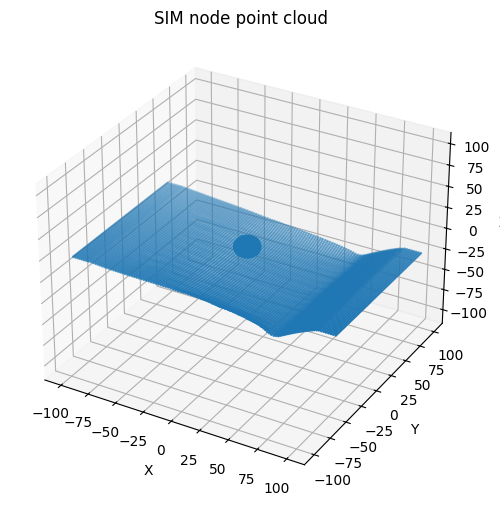

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if s.startswith("*") or s.startswith("$"):
                continue
            parts = s.split()
            if len(parts) < 4:
                continue
            nid = int(parts[0])
            x = float(parts[1]); y = float(parts[2]); z = float(parts[3])
            ids.append(nid)
            coords.append([x, y, z])
    return np.array(ids, dtype=int), np.array(coords, dtype=float)

sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")

print("SIM nodes:", sim_coords.shape[0])
print("mins:", sim_coords.min(axis=0))
print("maxs:", sim_coords.max(axis=0))
print("first 5 ids:", sim_ids[:5])
print("first 5 coords:\n", sim_coords[:5])

# Downsample for speed if huge
MAX_PLOT = 200000
if sim_coords.shape[0] > MAX_PLOT:
    idx = np.linspace(0, sim_coords.shape[0] - 1, MAX_PLOT).astype(int)
    plot_coords = sim_coords[idx]
    print(f"Downsampled to {plot_coords.shape[0]} points for plotting.")
else:
    plot_coords = sim_coords

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(plot_coords[:, 0], plot_coords[:, 1], plot_coords[:, 2], s=1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("SIM node point cloud")

# Approx equal axis scaling
mins = plot_coords.min(axis=0)
maxs = plot_coords.max(axis=0)
cent = 0.5 * (mins + maxs)
span = (maxs - mins).max()
ax.set_xlim(cent[0] - 0.5 * span, cent[0] + 0.5 * span)
ax.set_ylim(cent[1] - 0.5 * span, cent[1] + 0.5 * span)
ax.set_zlim(cent[2] - 0.5 * span, cent[2] + 0.5 * span)

plt.show()


### General function to plot the mesh

In [5]:
import numpy as np
import pyvista as pv

def plot_shell_field(coords,
                     conn,
                     ids,
                     vals,
                     title="vals"
                     ):

    # ---- assumed available from your loaders ----
    # ids:    (Ns,) int
    # coords: (Ns, 3)
    # vals:   (Ns,) float
    # conn:   (Ne, 4) int   # element connectivity in terms of node IDs

    # 1) Map node IDs -> index
    id_to_idx = {nid: i for i, nid in enumerate(ids)}

    # 2) Build nodal values aligned with coords
    nodal_mises = np.full(coords.shape[0], np.nan, dtype=float)
    for nid, val in zip(ids, vals):
        idx = id_to_idx.get(nid, None)
        if idx is not None:
            nodal_mises[idx] = val

    if np.any(np.isnan(nodal_mises)):
        print("Warning: some sim nodes have no value")

    # 3) Connectivity: node IDs -> 0-based indices
    conn = np.asarray(conn, dtype=int)
    nelems, nen = conn.shape  # nen should be 4

    conn_idx = np.zeros_like(conn, dtype=int)
    for e, nodes in enumerate(conn):
        conn_idx[e, :] = [id_to_idx[nid] for nid in nodes]

    # 4) VTK cells array for quads: [4, n1, n2, n3, n4, 4, n1, ...]
    cells = np.hstack(
        (
            np.full((nelems, 1), nen, dtype=np.int64),  # leading '4' per element
            conn_idx.astype(np.int64),
        )
    ).ravel()

    # Cell types: all QUAD
    celltypes = np.full(nelems, pv.CellType.QUAD, dtype=np.uint8)

    # 5) Build grid and attach σ_vM
    grid = pv.UnstructuredGrid(cells, celltypes, coords)
    grid["mises"] = nodal_mises

    xmin, xmax, ymin, ymax, zmin, zmax = grid.bounds
    # print(xmin, xmax)

    p = pv.Plotter()
    p.add_axes()
    p.show_bounds(grid='front', location='outer', all_edges=True)

    # p.enable_parallel_projection()
    p.add_mesh(
        grid,
        scalars="mises",
        cmap="jet",
        point_size=5,
        render_points_as_spheres=False,
        interpolate_before_map=True,
        show_scalar_bar=False,   # 🔹 turn off automatic bar
    )

    axes = p.show_bounds(
        grid='front',
        location='outer',
        all_edges=True,
        bounds=(xmin, xmax, ymin, ymax, zmin, zmax),
        axes_ranges=(xmin, xmax, ymin, ymax, zmin, zmax),
        n_xlabels=5,
        n_ylabels=5,
        n_zlabels=3,
        font_size=12,
        # optional:
        # n_xlabels=5,
        # n_ylabels=5,
    )

    axes.label_offset = 30.0

    p.add_scalar_bar(
        title=title,
        n_labels=5,
        vertical=True,
        position_x=0.88,
        position_y=0.1,
    )

    p.show()    

### Step 3: Computed sim SDV interpolated at exp nodal points

first task: we need to have the transformed sim coords as follows: 

1) they can be translated along 3 dim 
2) they can be scaled along 3 dim 
3) they can be rotated along 3 axis in total 9 unknowns. 

We need to find these 9 unknown such that the eucleadean norms between sim and exp coords are minimized. The number of NPs are different so finding closest NP of exp to sim is needed. If the geometry is symmatric like a rectangle or circle then this minimization does not have unique solution, so not only the eucleudean distance needs to be minimized but also the magnitude of the 9 unknowns as well.

However, scaling optimization would make the algorithm to cheat by squeezing the the sim mesh to be close to one single exp nodal point, so we would scaled it analytically using (max -min) of each dim between sim and exp

### Purely analytic strategy: only scaling and translating to match the max and min of exp

In [6]:
import numpy as np

def analytic_align_sim_to_exp(sim_coords, exp_coords):
    """
    Analytic alignment:
    1) Per-axis scaling from bbox ranges (sim -> exp)
    2) Per-axis translation so max(sim_scaled) = max(exp)

    sim_coords : (Ns, 3)
    exp_coords : (Ne, 3)

    Returns
    -------
    sim_coords_transformed : (Ns, 3)
        Scaled + translated sim coordinates.
    scale : (3,)
        Per-axis scales [sx, sy, sz].
    translation : (3,)
        Per-axis translations [tx, ty, tz] applied *after* scaling.
    """

    sim_coords = np.asarray(sim_coords, dtype=float)
    exp_coords = np.asarray(exp_coords, dtype=float)

    # --- 1) Compute per-axis scales from bounding box ranges ---
    sim_min = sim_coords.min(axis=0)
    sim_max = sim_coords.max(axis=0)
    exp_min = exp_coords.min(axis=0)
    exp_max = exp_coords.max(axis=0)

    sim_range = sim_max - sim_min
    exp_range = exp_max - exp_min

    scale = np.ones(3, dtype=float)
    for i in range(3):
        if sim_range[i] > 0.0:
            scale[i] = exp_range[i] / sim_range[i]
        else:
            scale[i] = 1.0  # avoid division by zero if perfectly flat

    # scale sim coords
    sim_scaled = sim_coords * scale  # broadcast along rows

    # --- 2) Compute translation so that max(sim_scaled) = max(exp) per axis ---
    sim_scaled_max = sim_scaled.max(axis=0)
    translation = exp_max - sim_scaled_max

    # apply translation
    sim_coords_transformed = sim_scaled + translation

    return sim_coords_transformed, scale, translation

sim_coords_transformed, s_vec, t_vec = analytic_align_sim_to_exp(sim_coords_sheet, exp_coords)

print("scale [sx, sy, sz]     =", s_vec)
print("translation [tx,ty,tz] =", t_vec)

import numpy as np

# Sim (transformed) bounds
sim_min = sim_coords_transformed.min(axis=0)
sim_max = sim_coords_transformed.max(axis=0)

# Exp bounds
exp_min = exp_coords.min(axis=0)
exp_max = exp_coords.max(axis=0)

print()
print("Transformed SIM bounds:")
print(f"  x: min = {sim_min[0]: .6f}, max = {sim_max[0]: .6f}")
print(f"  y: min = {sim_min[1]: .6f}, max = {sim_max[1]: .6f}")
print(f"  z: min = {sim_min[2]: .6f}, max = {sim_max[2]: .6f}")

print("\nEXP bounds:")
print(f"  x: min = {exp_min[0]: .6f}, max = {exp_max[0]: .6f}")
print(f"  y: min = {exp_min[1]: .6f}, max = {exp_max[1]: .6f}")
print(f"  z: min = {exp_min[2]: .6f}, max = {exp_max[2]: .6f}")

# Optional: show the differences in bounds
print("\nDifferences (SIM_transformed - EXP):")
print(f"  x: Δmin = {sim_min[0] - exp_min[0]: .6f}, Δmax = {sim_max[0] - exp_max[0]: .6f}")
print(f"  y: Δmin = {sim_min[1] - exp_min[1]: .6f}, Δmax = {sim_max[1] - exp_max[1]: .6f}")
print(f"  z: Δmin = {sim_min[2] - exp_min[2]: .6f}, Δmax = {sim_max[2] - exp_max[2]: .6f}")




scale [sx, sy, sz]     = [0.867215   1.0070178  1.19518891]
translation [tx,ty,tz] = [-1.14450000e-05 -1.52600000e-05 -3.11556717e-02]

Transformed SIM bounds:
  x: min = -99.729736, max =  99.729713
  y: min = -70.000038, max =  70.000008
  z: min = -28.640774, max =  0.000000

EXP bounds:
  x: min = -99.729736, max =  99.729713
  y: min = -70.000038, max =  70.000008
  z: min = -28.640774, max =  0.000000

Differences (SIM_transformed - EXP):
  x: Δmin =  0.000000, Δmax =  0.000000
  y: Δmin =  0.000000, Δmax =  0.000000
  z: Δmin =  0.000000, Δmax =  0.000000


### Plot the sim mesh at the new transformed coords

In [7]:
import numpy as np

def build_averaged_values_at_NPs(node_ids, elem_conn, elem_corner_vals):
    """
    Convert element-corner values (defined per element at its nodes) into a single
    averaged nodal value per node ID.

    Averaging is weighted purely by "how many elements share that node":
      nodal_value(n) = sum_over_incident_elements( value_at_that_element_corner ) / count_incident_elements

    Parameters
    ----------
    node_ids : (Nn,) int
        Global node IDs you want values for (e.g., sim_ids_sheet).
    elem_conn : (Ne, nen) int
        Element connectivity in NODE IDS (e.g., sim_conn_sheet). nen=4 for quads.
    elem_corner_vals : (Ne, nen) float
        Values at each element corner node in the same order as elem_conn
        (e.g., sim_thick_corner_sheet).

    Returns
    -------
    nodal_vals : (Nn,) float
        Averaged value at each node in `node_ids` order.
        Nodes not referenced by elem_conn will be NaN.
    counts : (Nn,) int
        Number of element-corner contributions accumulated for each node.
        (This is the divisor used in the average.)
    """
    node_ids = np.asarray(node_ids, dtype=int)
    elem_conn = np.asarray(elem_conn, dtype=int)
    elem_corner_vals = np.asarray(elem_corner_vals, dtype=float)

    if elem_conn.shape != elem_corner_vals.shape:
        raise ValueError(f"elem_conn shape {elem_conn.shape} must match elem_corner_vals shape {elem_corner_vals.shape}")

    id_to_idx = {nid: i for i, nid in enumerate(node_ids)}

    sums = np.zeros(node_ids.shape[0], dtype=float)
    counts = np.zeros(node_ids.shape[0], dtype=int)

    Ne, nen = elem_conn.shape
    for e in range(Ne):
        for a in range(nen):
            nid = int(elem_conn[e, a])
            idx = id_to_idx.get(nid, None)
            if idx is None:
                continue
            sums[idx] += float(elem_corner_vals[e, a])
            counts[idx] += 1

    nodal_vals = np.full(node_ids.shape[0], np.nan, dtype=float)
    mask = counts > 0
    nodal_vals[mask] = sums[mask] / counts[mask]

    return nodal_vals

sim_thick_corner_averaged_sheet = build_averaged_values_at_NPs(
    sim_ids_sheet,
    sim_conn_sheet,
    sim_thick_corner_sheet
)


### Plotting the sim thickness

C:\Users\springnuance\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


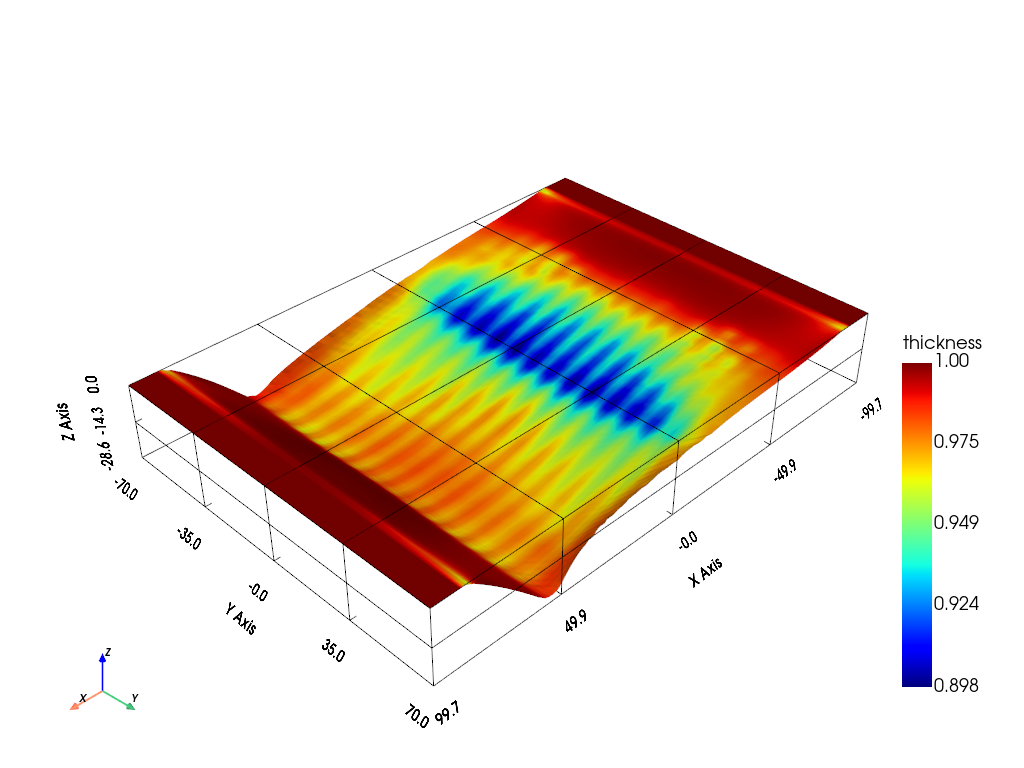

In [8]:
plot_shell_field(sim_coords_transformed, sim_conn_sheet, sim_ids, sim_thick_corner_averaged_sheet, title="thickness")

We need to finally interpolate for these quantites

sim_thick_corner_sheet: shape (num_elems_sim, nnode=4) to sim_thick_corner_sheet: shape (num_elems_exp, nnode=4) 

sim_stress_stress6_sheet: shape (num_elems_sim, ninpt_thickness=9, ntens=6) to exp_stress_stress6_sheet: shape (num_elems_exp, ninpt_thickness=9, ntens=6)

sim_stress_eqplas_sheet: shape (num_elems_sim, ninpt_thickness=9) to sim_stress_eqplas_sheet: shape (num_elems_exp, ninpt_thickness=9, ntens=6)

sim_strain_strain6_sheet: shape (num_elems_sim, ninpt_thickness=2, ntens=6) to exp_strain_strain6_sheet: shape (num_elems_exp, ninpt_thickness=2, ntens=6)

For the default Gauss through-thickness integration in initial strain, the two points are located symmetrically about the mid-plane at ±0.5774 in the normalized thickness coordinate (measured from the mid-plane). 

That means, conceptually:

lower IP = the point at negative thickness coordinate (−0.5774)

upper IP = the point at positive thickness coordinate (+0.5774)

We will ignore the ball in the interpolation task

### Interpolate element wise thickness corners

In [9]:
import numpy as np
from scipy.spatial import cKDTree

# ------------------------------------------------------------
# Helper: build 0-based connectivity from LS-DYNA node IDs
# ------------------------------------------------------------
def _build_conn_idx(conn_ids, node_ids):
    """
    Convert LS-DYNA node IDs in conn_ids (Ne,4) to 0-based indices
    into node coordinate arrays.
    """
    conn_ids = np.asarray(conn_ids, dtype=int)
    id_to_idx = {int(nid): i for i, nid in enumerate(node_ids)}
    conn_idx = np.zeros_like(conn_ids, dtype=int)
    for e in range(conn_ids.shape[0]):
        conn_idx[e, :] = [id_to_idx[int(n)] for n in conn_ids[e, :]]
    return conn_idx


# ------------------------------------------------------------
# Helper: Newton solve for (ξ,η) in a bilinear quad (2D)
# (your routine, kept the same spirit)
# ------------------------------------------------------------
def _local_coords_bilinear(xy_nodes, p, tol=1e-8, max_iter=15):
    """
    Solve for parent coords (ξ,η) such that bilinear mapping of quad corners
    hits p in the chosen 2D plane.

    xy_nodes: (4,2)
    p: (2,)
    Returns: xi, eta, converged(bool), inside(bool)
    """
    x_i = xy_nodes[:, 0]
    y_i = xy_nodes[:, 1]
    x_target, y_target = p

    xi = 0.0
    eta = 0.0

    for _ in range(max_iter):
        # Shape functions
        N = 0.25 * np.array([
            (1 - xi) * (1 - eta),
            (1 + xi) * (1 - eta),
            (1 + xi) * (1 + eta),
            (1 - xi) * (1 + eta),
        ], dtype=float)

        # Derivatives
        dN_dxi = 0.25 * np.array([
            -(1 - eta),
             (1 - eta),
             (1 + eta),
            -(1 + eta),
        ], dtype=float)

        dN_deta = 0.25 * np.array([
            -(1 - xi),
            -(1 + xi),
             (1 + xi),
             (1 - xi),
        ], dtype=float)

        x_cur = float(N @ x_i)
        y_cur = float(N @ y_i)

        r = np.array([x_cur - x_target, y_cur - y_target], dtype=float)
        if np.linalg.norm(r) < tol:
            inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
            return xi, eta, True, inside

        dx_dxi  = float(dN_dxi  @ x_i)
        dx_deta = float(dN_deta @ x_i)
        dy_dxi  = float(dN_dxi  @ y_i)
        dy_deta = float(dN_deta @ y_i)

        J = np.array([[dx_dxi, dx_deta],
                      [dy_dxi, dy_deta]], dtype=float)

        if abs(np.linalg.det(J)) < 1e-14:
            return xi, eta, False, False

        delta = np.linalg.solve(J, -r)
        xi  += float(delta[0])
        eta += float(delta[1])

    inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
    return xi, eta, False, inside


# ------------------------------------------------------------
# Main: interpolate SIM corner thickness onto EXP corner thickness
# (sheet only), using your "find containing quad" method.
# ------------------------------------------------------------
def interpolate_corner_thickness_2d(
    sim_coords_transformed,      # (Ns,3) FINAL sim coords for interpolation
    sim_ids,                     # (Ns,)
    sim_conn_sheet,              # (Ne_sim,4) node IDs, SHEET only
    sim_thick_corner_sheet,      # (Ne_sim,4) corner thickness per SIM element

    exp_coords,                  # (Nexp,3)
    exp_ids,                     # (Nexp,)
    exp_conn,                    # (Ne_exp,4) node IDs, EXP mesh

    projected_plane="XY",
    k_elem_candidates=24,
    tol_inside=1e-8,
    max_iter=15,
    fallback="nearest_element_mean",   # or "nearest_element_corner_mean"
    return_debug=False
):
    """
    Returns:
      exp_thick_corner_sheet: (Ne_exp,4)

    How it works:
      For each EXP element corner point:
        1) Find nearest SIM element centroids (KDTree)
        2) For each candidate SIM element:
             solve (xi,eta) s.t. p lies in that bilinear quad in 2D
             if inside: thickness = N(xi,eta) dot sim_thick_corner_sheet[element,:]
        3) If none found: fallback using nearest centroid element
    """

    # ---- choose projection axes ----
    plane = projected_plane.upper()
    if plane == "XY":
        ia, ib = 0, 1
    elif plane == "YZ":
        ia, ib = 1, 2
    elif plane == "XZ":
        ia, ib = 0, 2
    else:
        raise ValueError(f"Unsupported projected_plane: {projected_plane}")

    # ---- project SIM nodes to 2D ----
    sim_xy = np.column_stack([sim_coords_transformed[:, ia],
                              sim_coords_transformed[:, ib]])

    # ---- SIM connectivity: node IDs -> 0-based indices ----
    conn_idx = _build_conn_idx(sim_conn_sheet, sim_ids)  # (Ne_sim,4)
    ne_sim = conn_idx.shape[0]

    # ---- SIM element centroids (2D) + KDTree ----
    sim_cent = np.zeros((ne_sim, 2), dtype=float)
    for e in range(ne_sim):
        sim_cent[e, :] = sim_xy[conn_idx[e, :], :].mean(axis=0)

    tree_elems = cKDTree(sim_cent)

    # ---- EXP node map ----
    exp_id2i = {int(nid): i for i, nid in enumerate(exp_ids)}
    ne_exp = exp_conn.shape[0]

    # ---- outputs ----
    exp_thick_corner_sheet = np.zeros((ne_exp, 4), dtype=float)

    # ---- debug counters ----
    n_fallback = 0
    n_found = 0
    fallback_dist = []

    for ee in range(ne_exp):
        for a in range(4):
            nid = int(exp_conn[ee, a])
            p_xy = np.array([exp_coords[exp_id2i[nid], ia],
                             exp_coords[exp_id2i[nid], ib]], dtype=float)

            # candidate elements
            k = min(int(k_elem_candidates), ne_sim)
            d_e, idx_e = tree_elems.query(p_xy, k=k)
            if k == 1:
                idx_e = np.array([idx_e], dtype=int)
                d_e = np.array([d_e], dtype=float)

            found = False
            # try candidates
            for se in idx_e:
                se = int(se)
                node_idx = conn_idx[se, :]
                xy_nodes = sim_xy[node_idx, :]

                xi, eta, conv, inside = _local_coords_bilinear(
                    xy_nodes, p_xy, tol=tol_inside, max_iter=max_iter
                )
                if not inside:
                    continue

                # bilinear shape functions
                N = 0.25 * np.array([
                    (1 - xi) * (1 - eta),
                    (1 + xi) * (1 - eta),
                    (1 + xi) * (1 + eta),
                    (1 - xi) * (1 + eta),
                ], dtype=float)

                exp_thick_corner_sheet[ee, a] = float(N @ sim_thick_corner_sheet[se, :])
                found = True
                n_found += 1
                break

            if not found:
                # fallback: nearest centroid element
                d0, se0 = tree_elems.query(p_xy, k=1)
                se0 = int(se0)
                n_fallback += 1
                fallback_dist.append(float(d0))

                if fallback == "nearest_element_mean":
                    exp_thick_corner_sheet[ee, a] = float(sim_thick_corner_sheet[se0, :].mean())
                elif fallback == "nearest_element_corner_mean":
                    exp_thick_corner_sheet[ee, a] = float(np.mean(sim_thick_corner_sheet[se0, :]))
                else:
                    raise ValueError(f"Unsupported fallback mode: {fallback}")

    if return_debug:
        dbg = {
            "n_points_total": int(ne_exp * 4),
            "n_found": int(n_found),
            "n_fallback": int(n_fallback),
            "fallback_dist_min": float(np.min(fallback_dist)) if fallback_dist else 0.0,
            "fallback_dist_max": float(np.max(fallback_dist)) if fallback_dist else 0.0,
            "fallback_dist_mean": float(np.mean(fallback_dist)) if fallback_dist else 0.0,
        }
        return exp_thick_corner_sheet, dbg

    return exp_thick_corner_sheet

# --- call: interpolate EXP corner thickness from SIM sheet corner thickness ---
exp_thick_corner_sheet, dbg = interpolate_corner_thickness_2d(
    sim_coords_transformed=sim_coords_transformed,   # your final SIM coords for interpolation
    sim_ids=sim_ids,
    sim_conn_sheet=sim_conn_sheet,
    sim_thick_corner_sheet=sim_thick_corner_sheet,
    exp_coords=exp_coords,
    exp_ids=exp_ids,
    exp_conn=exp_conn,
    projected_plane="XY",
    k_elem_candidates=24,
    return_debug=True
)

# --- sanity prints ---
print("exp_thick_corner_sheet shape:", exp_thick_corner_sheet.shape)
print("expected shape:", (exp_conn.shape[0], 4))
print("debug:", dbg)

# --- sanity asserts ---
assert exp_thick_corner_sheet.shape == (exp_conn.shape[0], 4)
assert np.all(np.isfinite(exp_thick_corner_sheet)), "NaN/Inf found in exp_thick_corner_sheet"

# Optional: range check vs SIM thickness (helps catch bad alignment)
print("SIM thick min/max:", sim_thick_corner_sheet.min(), sim_thick_corner_sheet.max())
print("EXP thick min/max:", exp_thick_corner_sheet.min(), exp_thick_corner_sheet.max())



exp_thick_corner_sheet shape: (7560, 4)
expected shape: (7560, 4)
debug: {'n_points_total': 30240, 'n_found': 29560, 'n_fallback': 680, 'fallback_dist_min': 0.891222905160322, 'fallback_dist_max': 4.520933846356258, 'fallback_dist_mean': 2.1955479912118574}
SIM thick min/max: 0.894908 1.0
EXP thick min/max: 0.894908 1.0000000000000002


Lets look at the rest field, initial stress strain and eqplas. all of them are defined at gauss point at center through thickness. we can ignore the thickness values and treat them independently gauss point wise. For sim compute centroid for each element that will be the value in the data, and also compute pointwise centroids for all exp elements, and interpolate values at centroids of elements based on values at centroids of sim elements. (again we should use the projection XY XZ YZ plane) use that single function and run 6 +1+6 times (stress, eqplas, strain) and gets the result. it should compute pointwise via second dim and return (num elems exp, ninpt thickness) (could be any value)

In [10]:
# import numpy as np
# from scipy.spatial import cKDTree

# # ------------------------------------------------------------
# # Helpers
# # ------------------------------------------------------------
# def _build_conn_idx(conn_ids, node_ids):
#     """
#     Convert LS-DYNA node IDs in conn_ids (Ne,4) to 0-based indices
#     into node coordinate arrays.
#     """
#     conn_ids = np.asarray(conn_ids, dtype=int)
#     id_to_idx = {int(nid): i for i, nid in enumerate(node_ids)}
#     conn_idx = np.zeros_like(conn_ids, dtype=int)
#     for e in range(conn_ids.shape[0]):
#         conn_idx[e, :] = [id_to_idx[int(n)] for n in conn_ids[e, :]]
#     return conn_idx

# def _element_centroids_2d(coords3, conn_idx, ia, ib):
#     """
#     coords3: (N,3)
#     conn_idx: (Ne,4) 0-based indices
#     returns centroids in chosen plane: (Ne,2)
#     """
#     xy = np.column_stack([coords3[:, ia], coords3[:, ib]])
#     ne = conn_idx.shape[0]
#     cent = np.zeros((ne, 2), dtype=float)
#     for e in range(ne):
#         cent[e, :] = xy[conn_idx[e, :], :].mean(axis=0)
#     return cent

# def _idw_knn(src_xy, src_val, dst_xy, k=12, eps=1e-12):
#     """
#     IDW kNN interpolation.
#     src_xy: (Ns,2)
#     src_val: (Ns, ...) any trailing shape
#     dst_xy: (Nd,2)
#     returns: (Nd, ...) same trailing shape
#     """
#     src_val = np.asarray(src_val)
#     tree = cKDTree(src_xy)

#     k_eff = min(int(k), src_xy.shape[0])
#     d, idx = tree.query(dst_xy, k=k_eff)

#     # k=1
#     if k_eff == 1:
#         return src_val[idx]

#     # weights: (Nd,k)
#     w = 1.0 / (d + eps)
#     w /= w.sum(axis=1, keepdims=True)

#     gathered = src_val[idx]  # (Nd,k,...)  (advanced indexing)

#     # reshape weights to (Nd,k,1,1,...)
#     extra = (1,) * (gathered.ndim - 2)
#     w_shaped = w.reshape(w.shape[0], w.shape[1], *extra)

#     return (w_shaped * gathered).sum(axis=1)


# # ------------------------------------------------------------
# # Main: centroid-based GP-field mapping SIM->EXP (sheet only)
# # ------------------------------------------------------------
# def interpolate_gp_fields_by_centroids_2d(
#     sim_coords_transformed, sim_ids, sim_conn_sheet,
#     exp_coords, exp_ids, exp_conn,
#     sim_field,                       # (Ne_sim, ...) e.g. (Ne_sim,9,6) or (Ne_sim,9) or (Ne_sim,2,6)
#     projected_plane="XY",
#     k_neigh=12
# ):
#     """
#     Centroid-based interpolation for GP-defined element fields.

#     - Compute SIM element centroids (2D projection)
#     - Compute EXP element centroids (2D projection)
#     - Interpolate sim_field from SIM centroids to EXP centroids using IDW kNN

#     Returns:
#       exp_field of shape (Ne_exp, ...) matching sim_field trailing dims.
#     """

#     # ---- plane indices ----
#     plane = projected_plane.upper()
#     if plane == "XY":
#         ia, ib = 0, 1
#     elif plane == "YZ":
#         ia, ib = 1, 2
#     elif plane == "XZ":
#         ia, ib = 0, 2
#     else:
#         raise ValueError(f"Unsupported projected_plane: {projected_plane}")

#     # ---- build conn indices ----
#     sim_conn_idx = _build_conn_idx(sim_conn_sheet, sim_ids)
#     exp_conn_idx = _build_conn_idx(exp_conn, exp_ids)

#     # ---- centroids in projected plane ----
#     sim_cent = _element_centroids_2d(sim_coords_transformed, sim_conn_idx, ia, ib)  # (Ne_sim,2)
#     exp_cent = _element_centroids_2d(exp_coords,          exp_conn_idx, ia, ib)     # (Ne_exp,2)

#     sim_field = np.asarray(sim_field)
#     if sim_field.shape[0] != sim_cent.shape[0]:
#         raise ValueError(
#             f"sim_field first dim {sim_field.shape[0]} != num SIM elems {sim_cent.shape[0]} "
#             f"(did you pass sheet-only sim_field aligned with sim_conn_sheet?)"
#         )

#     # ---- interpolate ----
#     exp_field = _idw_knn(sim_cent, sim_field, exp_cent, k=k_neigh)
#     return exp_field


# # ============================================================
# # CALLS (sheet only) — using your variable names
# # ============================================================

# # Stress: (Ne_sim, 9, 6) -> (Ne_exp, 9, 6)
# exp_stress_stress6_sheet = interpolate_gp_fields_by_centroids_2d(
#     sim_coords_transformed=sim_coords_transformed,
#     sim_ids=sim_ids,
#     sim_conn_sheet=sim_conn_sheet,
#     exp_coords=exp_coords,
#     exp_ids=exp_ids,
#     exp_conn=exp_conn,
#     sim_field=sim_stress_stress6_sheet,
#     projected_plane="XY",
#     k_neigh=2
# )

# # Eqplas: (Ne_sim, 9) -> (Ne_exp, 9)
# exp_stress_eqplas_sheet = interpolate_gp_fields_by_centroids_2d(
#     sim_coords_transformed=sim_coords_transformed,
#     sim_ids=sim_ids,
#     sim_conn_sheet=sim_conn_sheet,
#     exp_coords=exp_coords,
#     exp_ids=exp_ids,
#     exp_conn=exp_conn,
#     sim_field=sim_stress_eqplas_sheet,
#     projected_plane="XY",
#     k_neigh=2
# )

# # Strain: (Ne_sim, 2, 6) -> (Ne_exp, 2, 6)
# exp_strain_strain6_sheet = interpolate_gp_fields_by_centroids_2d(
#     sim_coords_transformed=sim_coords_transformed,
#     sim_ids=sim_ids,
#     sim_conn_sheet=sim_conn_sheet,
#     exp_coords=exp_coords,
#     exp_ids=exp_ids,
#     exp_conn=exp_conn,
#     sim_field=sim_strain_strain6_sheet,
#     projected_plane="XY",
#     k_neigh=2
# )

# # ============================================================
# # SANITY: shapes + finiteness
# # ============================================================
# print("exp_stress_stress6_sheet shape:", exp_stress_stress6_sheet.shape, " expected:", (exp_conn.shape[0], 9, 6))
# print("exp_stress_eqplas_sheet  shape:", exp_stress_eqplas_sheet.shape,  " expected:", (exp_conn.shape[0], 9))
# print("exp_strain_strain6_sheet shape:", exp_strain_strain6_sheet.shape, " expected:", (exp_conn.shape[0], 2, 6))

# assert exp_stress_stress6_sheet.shape == (exp_conn.shape[0], 9, 6)
# assert exp_stress_eqplas_sheet.shape  == (exp_conn.shape[0], 9)
# assert exp_strain_strain6_sheet.shape == (exp_conn.shape[0], 2, 6)

# assert np.all(np.isfinite(exp_stress_stress6_sheet)), "NaN/Inf in exp_stress_stress6_sheet"
# assert np.all(np.isfinite(exp_stress_eqplas_sheet)),  "NaN/Inf in exp_stress_eqplas_sheet"
# assert np.all(np.isfinite(exp_strain_strain6_sheet)), "NaN/Inf in exp_strain_strain6_sheet"

# # Optional: quick min/max comparisons
# print("SIM stress min/max:", sim_stress_stress6_sheet.min(), sim_stress_stress6_sheet.max())
# print("EXP stress min/max:", exp_stress_stress6_sheet.min(), exp_stress_stress6_sheet.max())
# print("SIM eqplas min/max:", sim_stress_eqplas_sheet.min(), sim_stress_eqplas_sheet.max())
# print("EXP eqplas min/max:", exp_stress_eqplas_sheet.min(), exp_stress_eqplas_sheet.max())
# print("SIM strain min/max:", sim_strain_strain6_sheet.min(), sim_strain_strain6_sheet.max())
# print("EXP strain min/max:", exp_strain_strain6_sheet.min(), exp_strain_strain6_sheet.max())


In [11]:
import numpy as np
from scipy.spatial import cKDTree

# ------------------------------------------------------------
# Helper: build 0-based connectivity from LS-DYNA node IDs
# ------------------------------------------------------------
def _build_conn_idx(conn, ids):
    conn = np.asarray(conn, dtype=int)
    id_to_idx = {int(nid): i for i, nid in enumerate(ids)}
    conn_idx = np.zeros_like(conn, dtype=int)
    for e in range(conn.shape[0]):
        conn_idx[e, :] = [id_to_idx[int(n)] for n in conn[e, :]]
    return conn_idx


# ------------------------------------------------------------
# Helper: Newton solve for (ξ,η) in a bilinear quad (same as yours)
# ------------------------------------------------------------
def _local_coords_bilinear(xy_nodes, p, tol=1e-8, max_iter=15):
    x_i = xy_nodes[:, 0]
    y_i = xy_nodes[:, 1]
    x_target, y_target = p

    xi = 0.0
    eta = 0.0

    for _ in range(max_iter):
        N1 = 0.25 * (1 - xi) * (1 - eta)
        N2 = 0.25 * (1 + xi) * (1 - eta)
        N3 = 0.25 * (1 + xi) * (1 + eta)
        N4 = 0.25 * (1 - xi) * (1 + eta)
        N = np.array([N1, N2, N3, N4], dtype=float)

        dN_dxi = 0.25 * np.array([-(1 - eta), (1 - eta), (1 + eta), -(1 + eta)], dtype=float)
        dN_deta = 0.25 * np.array([-(1 - xi), -(1 + xi), (1 + xi), (1 - xi)], dtype=float)

        x_cur = float(N @ x_i)
        y_cur = float(N @ y_i)

        r = np.array([x_cur - x_target, y_cur - y_target], dtype=float)
        if np.linalg.norm(r) < tol:
            inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
            return xi, eta, True, inside

        dx_dxi  = float(dN_dxi  @ x_i)
        dx_deta = float(dN_deta @ x_i)
        dy_dxi  = float(dN_dxi  @ y_i)
        dy_deta = float(dN_deta @ y_i)

        J = np.array([[dx_dxi, dx_deta],
                      [dy_dxi, dy_deta]], dtype=float)

        if abs(np.linalg.det(J)) < 1e-14:
            return xi, eta, False, False

        delta = np.linalg.solve(J, -r)
        xi  += float(delta[0])
        eta += float(delta[1])

    inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
    return xi, eta, False, inside


# ------------------------------------------------------------
# Element centroid computation in a chosen projection plane
# ------------------------------------------------------------
def _element_centroids_2d(coords3, conn_idx, ia, ib):
    xy = np.column_stack([coords3[:, ia], coords3[:, ib]])
    ne = conn_idx.shape[0]
    cent = np.zeros((ne, 2), dtype=float)
    for e in range(ne):
        cent[e, :] = xy[conn_idx[e, :], :].mean(axis=0)
    return cent, xy


# ------------------------------------------------------------
# Main: GP/centroid field transfer using your containment search
# ------------------------------------------------------------
def interpolate_gp_by_centroids_containment(
    sim_coords_transformed,
    sim_ids,
    sim_conn_sheet,
    exp_coords,
    exp_ids,
    exp_conn,
    sim_field,                 # (Ne_sim, ...) e.g. (Ne_sim,9,6) or (Ne_sim,9) or (Ne_sim,2,6)
    projected_plane="XY",
    k_elem_candidates=24,
    tol=1e-8,
    max_iter=15,
    return_debug=False
):
    """
    For each EXP element centroid (treated as NP):
      - find a containing SIM element (in 2D projection) using Newton inversion
      - assign EXP element value = SIM element GP payload (sim_field[sim_elem])
      - fallback: nearest SIM centroid (KDTree)

    Returns:
      exp_field: (Ne_exp, ...) matching sim_field trailing dims
    """

    # --- choose projection indices ---
    plane = projected_plane.upper()
    if plane == "XY":
        ia, ib = 0, 1
    elif plane == "YZ":
        ia, ib = 1, 2
    elif plane == "XZ":
        ia, ib = 0, 2
    else:
        raise ValueError(f"Unsupported projected_plane: {projected_plane}")

    # --- SIM connectivity indices + SIM centroids ---
    sim_conn_idx = _build_conn_idx(sim_conn_sheet, sim_ids)
    sim_cent, sim_xy = _element_centroids_2d(sim_coords_transformed, sim_conn_idx, ia, ib)

    ne_sim = sim_conn_idx.shape[0]
    if sim_field.shape[0] != ne_sim:
        raise ValueError(f"sim_field first dim {sim_field.shape[0]} != num SIM elems {ne_sim}")

    # KDTree on SIM element centroids (for candidate search + fallback)
    tree_elems = cKDTree(sim_cent)

    # --- EXP connectivity indices + EXP centroids ---
    exp_conn_idx = _build_conn_idx(exp_conn, exp_ids)
    exp_cent, _ = _element_centroids_2d(exp_coords, exp_conn_idx, ia, ib)
    ne_exp = exp_conn_idx.shape[0]

    # --- output ---
    exp_field = np.zeros((ne_exp,) + sim_field.shape[1:], dtype=float)

    # --- debug ---
    n_found = 0
    n_fallback = 0
    fallback_dist = []

    # loop exp element centroids (treated as "NPs")
    for ee in range(ne_exp):
        p = exp_cent[ee, :]

        # candidate SIM elements by centroid
        k = min(int(k_elem_candidates), ne_sim)
        d_e, idx_e = tree_elems.query(p, k=k)
        if k == 1:
            idx_e = np.array([idx_e], dtype=int)

        found = False
        chosen_se = None

        for se in idx_e:
            se = int(se)
            node_idx = sim_conn_idx[se, :]
            xy_nodes = sim_xy[node_idx, :]  # (4,2)

            xi, eta, conv, inside = _local_coords_bilinear(
                xy_nodes, p, tol=tol, max_iter=max_iter
            )
            if not inside:
                continue

            chosen_se = se
            found = True
            break

        if not found:
            # fallback: nearest centroid
            d0, se0 = tree_elems.query(p, k=1)
            chosen_se = int(se0)
            n_fallback += 1
            fallback_dist.append(float(d0))
        else:
            n_found += 1

        # IMPORTANT: centroid/GP field -> take element payload directly
        exp_field[ee, ...] = sim_field[chosen_se, ...]

    if return_debug:
        dbg = {
            "n_elems_exp": int(ne_exp),
            "n_found": int(n_found),
            "n_fallback": int(n_fallback),
            "fallback_dist_min": float(np.min(fallback_dist)) if fallback_dist else 0.0,
            "fallback_dist_max": float(np.max(fallback_dist)) if fallback_dist else 0.0,
            "fallback_dist_mean": float(np.mean(fallback_dist)) if fallback_dist else 0.0,
        }
        return exp_field, dbg

    return exp_field


# ============================================================
# USE IT FOR YOUR THREE FIELDS (sheet only)
# ============================================================

# stress: (Ne_sim,9,6) -> (Ne_exp,9,6)
exp_stress_stress6_sheet, dbg_stress = interpolate_gp_by_centroids_containment(
    sim_coords_transformed=sim_coords_transformed,
    sim_ids=sim_ids,
    sim_conn_sheet=sim_conn_sheet,
    exp_coords=exp_coords,
    exp_ids=exp_ids,
    exp_conn=exp_conn,
    sim_field=sim_stress_stress6_sheet,
    projected_plane="XY",
    k_elem_candidates=24,
    return_debug=True
)

# eqplas: (Ne_sim,9) -> (Ne_exp,9)
exp_stress_eqplas_sheet, dbg_eqp = interpolate_gp_by_centroids_containment(
    sim_coords_transformed=sim_coords_transformed,
    sim_ids=sim_ids,
    sim_conn_sheet=sim_conn_sheet,
    exp_coords=exp_coords,
    exp_ids=exp_ids,
    exp_conn=exp_conn,
    sim_field=sim_stress_eqplas_sheet,
    projected_plane="XY",
    k_elem_candidates=24,
    return_debug=True
)

# strain: (Ne_sim,2,6) -> (Ne_exp,2,6)
exp_strain_strain6_sheet, dbg_strain = interpolate_gp_by_centroids_containment(
    sim_coords_transformed=sim_coords_transformed,
    sim_ids=sim_ids,
    sim_conn_sheet=sim_conn_sheet,
    exp_coords=exp_coords,
    exp_ids=exp_ids,
    exp_conn=exp_conn,
    sim_field=sim_strain_strain6_sheet,
    projected_plane="XY",
    k_elem_candidates=24,
    return_debug=True
)

print("debug stress:", dbg_stress)
print("debug eqplas:", dbg_eqp)
print("debug strain:", dbg_strain)

print("exp_stress_stress6_sheet shape:", exp_stress_stress6_sheet.shape, " expected:", (exp_conn.shape[0], 9, 6))
print("exp_stress_eqplas_sheet  shape:", exp_stress_eqplas_sheet.shape,  " expected:", (exp_conn.shape[0], 9))
print("exp_strain_strain6_sheet shape:", exp_strain_strain6_sheet.shape, " expected:", (exp_conn.shape[0], 2, 6))

assert exp_stress_stress6_sheet.shape == (exp_conn.shape[0], 9, 6)
assert exp_stress_eqplas_sheet.shape  == (exp_conn.shape[0], 9)
assert exp_strain_strain6_sheet.shape == (exp_conn.shape[0], 2, 6)

assert np.all(np.isfinite(exp_stress_stress6_sheet))
assert np.all(np.isfinite(exp_stress_eqplas_sheet))
assert np.all(np.isfinite(exp_strain_strain6_sheet))

print("SIM stress min/max:", sim_stress_stress6_sheet.min(), sim_stress_stress6_sheet.max())
print("EXP stress min/max:", exp_stress_stress6_sheet.min(), exp_stress_stress6_sheet.max())

print("SIM eqplas min/max:", sim_stress_eqplas_sheet.min(), sim_stress_eqplas_sheet.max())
print("EXP eqplas min/max:", exp_stress_eqplas_sheet.min(), exp_stress_eqplas_sheet.max())

print("SIM strain min/max:", sim_strain_strain6_sheet.min(), sim_strain_strain6_sheet.max())
print("EXP strain min/max:", exp_strain_strain6_sheet.min(), exp_strain_strain6_sheet.max())


debug stress: {'n_elems_exp': 7560, 'n_found': 7416, 'n_fallback': 144, 'fallback_dist_min': 0.7619097685830297, 'fallback_dist_max': 3.523343492188585, 'fallback_dist_mean': 2.071620682352761}
debug eqplas: {'n_elems_exp': 7560, 'n_found': 7416, 'n_fallback': 144, 'fallback_dist_min': 0.7619097685830297, 'fallback_dist_max': 3.523343492188585, 'fallback_dist_mean': 2.071620682352761}
debug strain: {'n_elems_exp': 7560, 'n_found': 7416, 'n_fallback': 144, 'fallback_dist_min': 0.7619097685830297, 'fallback_dist_max': 3.523343492188585, 'fallback_dist_mean': 2.071620682352761}
exp_stress_stress6_sheet shape: (7560, 9, 6)  expected: (7560, 9, 6)
exp_stress_eqplas_sheet  shape: (7560, 9)  expected: (7560, 9)
exp_strain_strain6_sheet shape: (7560, 2, 6)  expected: (7560, 2, 6)
SIM stress min/max: -1156.02 935.3877
EXP stress min/max: -1156.02 935.3877
SIM eqplas min/max: 0.0 7.715434
EXP eqplas min/max: 0.0 7.715434
SIM strain min/max: -0.26992 0.264648
EXP strain min/max: -0.26992 0.264648

Finally, we need to reconstruct the file from interpolated exp data as follows

For *ELEMENT_SHELL_THICKNESS, node ID has 8 characters, right padded. part id is always 2, 8 characters right padded (so in this case 7 empty spaces pad). node ID making up shell elements also 8 characters right padded, then under each line is 4 thickness values of exactly 12 chars scientific format, right padded 4 empty spaces.

for *NODE, node coordinates are scientic values containing exactly 15 chars and the x y z coords are separated by 2 spaces (also from node ID). node ID has 8 characters,  right padded

for *INITIAL_STRESS_SHELL, the 9 values: -9.6816E-1 to 9.68160E-1 in INITIAL_STRESS_SHELL are fixed so we will keep them as exactly like that
For each value in INITIAL STRESS and INITIAL STRAIN it is scientific format of 10 characters including minus sign, dot, exponent symbol E, etc

```text
*KEYWORD
$TIME_VALUE =  4.5304899e+00
$STATE_NO = 92
$Output for State 92 at time = 4.53049
*ELEMENT_SHELL_THICKNESS
 node_ID       2   node_ID_1   node_ID_2   node_ID_3   node_ID_4
    9.203683e-01    9.203683e-01    9.203683e-01    9.203683e-01
...
*NODE
   46918  -2.6594168e+01  -5.3695913e+01  -8.0397541e+00
...
*INITIAL_STRESS_SHELL
$      eid    nplane    nthick     nhisv
   node_ID         1         9         0
-9.6816E-1-2.07649E12.044839E2-1.50171E11.152362E26.550317E1-1.92293E15.13743E-1
-8.3603E-1-4.60621E12.525129E2-2.59859E11.326099E27.356751E1-3.61201E13.70429E-1
-6.1337E-1-1.10948E23.088656E2-5.26694E11.109214E26.122646E1-7.81245E11.68750E-1
-3.2425E-1-1.80087E23.028666E2-8.24537E1-2.50585E1-1.66135E1-1.24101E26.14185E-2
       0.03.418246E14.236349E1-1.06580E12.714494E11.117024E1-3.9658E-34.23180E-2
3.24253E-12.492098E2-2.49854E26.038593E18.518252E14.602219E11.236532E29.32521E-2
6.13371E-11.452689E2-2.32427E22.973929E1-3.96435E1-1.84170E16.721951E12.09971E-1
8.36031E-11.204690E1-1.24482E2-5.58389E0-5.60660E1-2.65667E1-1.60351E04.00387E-1
9.68160E-1-4.59957E0-1.02157E2-1.07243E1-4.96265E1-2.26640E1-1.08522E15.34698E-1
*INITIAL_STRAIN_SHELL
$      eid
     42525
3.56051E-27.80833E-3-4.3467E-2-8.6929E-31.96972E-3-9.0623E-3
3.48259E-2-2.2791E-2-1.2073E-2-2.1045E-3-2.0315E-3-4.9821E-3
...
*END
```

so you write a function and then write 4 files exp_coords_NPs.txt (include the *NODE) exp_element_shell_thickness.txt (include *ELEMENT_SHELL_THICKNESS= exp_initial_strain_shell.txt (so on) exp_initial_stress_shell.txt (also contains keyword) and then fianlyl concatenate them and add *KEYWORD $TIME_VALUE = 4.5304899e+00 $STATE_NO = 92 $Output for State 92 at time = 4.53049 ... 4 files *END and write as interpolated_dynain_export_for_stl.k so i can proofread


In [12]:
import numpy as np
from pathlib import Path

# ============================================================
# Fixed-format helpers (match your LS-DYNA export conventions)
# ============================================================

def _i8(x: int) -> str:
    """8-character integer field (right aligned, like your sample)."""
    return f"{int(x):8d}"

def _f15(x: float) -> str:
    """
    Node coord: scientific, exactly 15 chars (lowercase e),
    coords will be separated by TWO spaces outside this function.
    """
    return f"{float(x):15.7e}"

def _f12_plus4(x: float) -> str:
    """
    Thickness value: 12-char scientific (lowercase e), then 4 spaces padding.
    Total field = 16 chars per value.
    """
    return f"{float(x):12.6e}" + "    "

def _f10_dyna(x: float) -> str:
    """
    LS-DYNA packed 10-char scientific field that resembles your exports:
      - one digit before decimal
      - exponent has no '+' for positive
      - exponent uses '-' for negative
      - total length exactly 10 (left padded with spaces if needed)

    Examples you showed: -2.07649E1, 2.044839E2, 5.13743E-1
    """
    x = float(x)
    if x == 0.0:
        # exponent = 0 (positive, 1 digit), decimals chosen to hit length 10
        s = "0.000000E0"  # 10 chars
        return s

    sign = "-" if x < 0.0 else ""
    ax = abs(x)

    exp = int(np.floor(np.log10(ax)))
    mant = ax / (10.0 ** exp)

    # handle rounding that could push mant to 10.0
    if mant >= 9.9999995:
        mant = 1.0
        exp += 1

    exp_str = f"-{abs(exp)}" if exp < 0 else f"{exp}"  # NO '+' for positive

    # exp_len counts chars AFTER 'E'
    exp_len = len(exp_str)

    # total length target = 10:
    # sign_len + (1 digit) + '.' + ndp + 'E' + exp_len = 10
    sign_len = 1 if sign else 0
    ndp = 7 - sign_len - exp_len
    if ndp < 0:
        ndp = 0  # extremely rare unless exp has many digits

    if ndp == 0:
        mant_str = f"{mant:.0f}."
    else:
        mant_str = f"{mant:.{ndp}f}"

    s = f"{sign}{mant_str}E{exp_str}"

    # enforce exact width 10 by left-padding or trimming (should rarely trim)
    if len(s) < 10:
        s = " " * (10 - len(s)) + s
    elif len(s) > 10:
        # if it ever happens, reduce decimals by trimming mantissa part
        s = s[:10]

    return s


# Fixed 9 zeta fields you want to keep EXACTLY as in LS-DYNA
ZETA9_FIELDS = [
    "-9.6816E-1",
    "-8.3603E-1",
    "-6.1337E-1",
    "-3.2425E-1",
    "       0.0",  # 10 chars
    "3.24253E-1",
    "6.13371E-1",
    "8.36031E-1",
    "9.68160E-1",
]
assert all(len(z) == 10 for z in ZETA9_FIELDS), "ZETA9_FIELDS must be 10 chars each"


# ============================================================
# Writers for each section file
# ============================================================

def write_exp_coords_nodes_file(exp_coords_NPs_path, exp_ids, exp_coords):
    """
    Writes exp_coords_NPs.txt containing *NODE block only.
    Format:
      nodeID(8) + two spaces + x(15) + two spaces + y(15) + two spaces + z(15)
    """
    exp_coords_NPs_path = Path(exp_coords_NPs_path)

    exp_ids = np.asarray(exp_ids, dtype=int)
    exp_coords = np.asarray(exp_coords, dtype=float)
    assert exp_coords.shape == (exp_ids.shape[0], 3)

    with exp_coords_NPs_path.open("w") as f:
        f.write("*NODE\n")
        # Optional comment line (safe)
        # f.write("$     nid        x               y               z\n")
        for nid, (x, y, z) in zip(exp_ids, exp_coords):
            line = _i8(nid) + "  " + _f15(x) + "  " + _f15(y) + "  " + _f15(z) + "\n"
            f.write(line)

    return exp_coords_NPs_path


def write_exp_element_shell_thickness_file(exp_element_shell_thickness_path,
                                          exp_eids, exp_conn, exp_thick_corner_sheet, pid=2):
    """
    Writes exp_element_shell_thickness.txt containing *ELEMENT_SHELL_THICKNESS only.

    First line per element:
      eid(8) pid(8) n1(8) n2(8) n3(8) n4(8)
    Second line per element:
      4 thickness values, each = 12-char scientific + 4 spaces padding
    """
    exp_element_shell_thickness_path = Path(exp_element_shell_thickness_path)

    exp_eids = np.asarray(exp_eids, dtype=int)
    exp_conn = np.asarray(exp_conn, dtype=int)
    exp_thick_corner_sheet = np.asarray(exp_thick_corner_sheet, dtype=float)

    assert exp_conn.shape == (exp_eids.shape[0], 4)
    assert exp_thick_corner_sheet.shape == (exp_eids.shape[0], 4)

    with exp_element_shell_thickness_path.open("w") as f:
        f.write("*ELEMENT_SHELL_THICKNESS\n")
        # Optional comment line (safe)
        # f.write("$     eid     pid      n1      n2      n3      n4\n")

        for eid, conn, thick4 in zip(exp_eids, exp_conn, exp_thick_corner_sheet):
            f.write(_i8(eid) + _i8(pid) + "".join(_i8(n) for n in conn) + "\n")
            f.write("".join(_f12_plus4(t) for t in thick4) + "\n")

    return exp_element_shell_thickness_path


def write_exp_initial_stress_shell_file(exp_initial_stress_shell_path,
                                       exp_eids,
                                       exp_stress_stress6_sheet,
                                       exp_stress_eqplas_sheet):
    """
    Writes exp_initial_stress_shell.txt containing *INITIAL_STRESS_SHELL only.

    Header line for each element (like your sample):
      eid(10) nplane(10) nthick(10) nhisv(10)
    Then 9 lines (nthick=9), each packed:
      zeta(10 fixed string) + sxx(10) + syy(10) + szz(10) + sxy(10) + syz(10) + szx(10) + eqplas(10)
    """
    exp_initial_stress_shell_path = Path(exp_initial_stress_shell_path)

    exp_eids = np.asarray(exp_eids, dtype=int)
    exp_stress_stress6_sheet = np.asarray(exp_stress_stress6_sheet, dtype=float)
    exp_stress_eqplas_sheet = np.asarray(exp_stress_eqplas_sheet, dtype=float)

    assert exp_stress_stress6_sheet.shape[0] == exp_eids.shape[0]
    assert exp_stress_stress6_sheet.shape[1:] == (9, 6)
    assert exp_stress_eqplas_sheet.shape == (exp_eids.shape[0], 9)

    with exp_initial_stress_shell_path.open("w") as f:
        f.write("*INITIAL_STRESS_SHELL\n")
        f.write("$      eid    nplane    nthick     nhisv\n")

        for i, eid in enumerate(exp_eids):
            f.write(f"{eid:10d}{1:10d}{9:10d}{0:10d}\n")

            for k in range(9):
                zeta = ZETA9_FIELDS[k]  # exactly 10 chars
                sxx, syy, szz, sxy, syz, szx = exp_stress_stress6_sheet[i, k, :]
                eqp = exp_stress_eqplas_sheet[i, k]

                line = (
                    zeta
                    + _f10_dyna(sxx)
                    + _f10_dyna(syy)
                    + _f10_dyna(szz)
                    + _f10_dyna(sxy)
                    + _f10_dyna(syz)
                    + _f10_dyna(szx)
                    + _f10_dyna(eqp)
                    + "\n"
                )

                # sanity: 10 + 7*10 = 80 chars before newline
                assert len(line.rstrip("\n")) == 80
                f.write(line)

    return exp_initial_stress_shell_path


def write_exp_initial_strain_shell_file(exp_initial_strain_shell_path,
                                       exp_eids,
                                       exp_strain_strain6_sheet):
    """
    Writes exp_initial_strain_shell.txt containing *INITIAL_STRAIN_SHELL only.

    For each element:
      eid line: (10d)
      then 2 lines (nthick=2), each packed 6 strain components (6*10 chars):
        exx eyy ezz exy eyz ezx (each 10-char _f10_dyna)
    """
    exp_initial_strain_shell_path = Path(exp_initial_strain_shell_path)

    exp_eids = np.asarray(exp_eids, dtype=int)
    exp_strain_strain6_sheet = np.asarray(exp_strain_strain6_sheet, dtype=float)

    assert exp_strain_strain6_sheet.shape[0] == exp_eids.shape[0]
    assert exp_strain_strain6_sheet.shape[1:] == (2, 6)

    with exp_initial_strain_shell_path.open("w") as f:
        f.write("*INITIAL_STRAIN_SHELL\n")
        f.write("$      eid\n")

        for i, eid in enumerate(exp_eids):
            f.write(f"{eid:10d}\n")
            for k in range(2):
                vals6 = exp_strain_strain6_sheet[i, k, :]
                line = "".join(_f10_dyna(v) for v in vals6) + "\n"
                assert len(line.rstrip("\n")) == 60
                f.write(line)

    return exp_initial_strain_shell_path


# ============================================================
# Concatenation into final dynain-style export
# ============================================================

def write_interpolated_dynain_export_for_stl(
    out_k_path,
    exp_coords_NPs_path,
    exp_element_shell_thickness_path,
    exp_initial_stress_shell_path,
    exp_initial_strain_shell_path,
    time_value_str="  4.5304899e+00",
    state_no=92,
    output_time_str="4.53049",
):
    """
    Creates interpolated_dynain_export_for_stl.k by concatenating:
      1) *ELEMENT_SHELL_THICKNESS (file)
      2) *NODE (file)
      3) *INITIAL_STRESS_SHELL (file)
      4) *INITIAL_STRAIN_SHELL (file)
    with *KEYWORD header and *END tail.
    """
    out_k_path = Path(out_k_path)

    def _read_text(p):
        return Path(p).read_text()

    header = (
        "*KEYWORD\n"
        f"$TIME_VALUE = {time_value_str}\n"
        f"$STATE_NO = {int(state_no)}\n"
        f"$Output for State {int(state_no)} at time = {output_time_str}\n"
    )

    body = (
        _read_text(exp_element_shell_thickness_path)
        + _read_text(exp_coords_NPs_path)
        + _read_text(exp_initial_stress_shell_path)
        + _read_text(exp_initial_strain_shell_path)
    )

    tail = "*END\n"

    out_k_path.write_text(header + body + tail)
    return out_k_path


# ============================================================
# One-shot driver (uses your existing variable names)
# ============================================================

# Required variables you already have:
# exp_ids, exp_coords
# exp_eids, exp_conn
# exp_thick_corner_sheet
# exp_stress_stress6_sheet, exp_stress_eqplas_sheet
# exp_strain_strain6_sheet

exp_coords_NPs_path = write_exp_coords_nodes_file(
    "exp_coords_NPs.txt",
    exp_ids=exp_ids,
    exp_coords=exp_coords,
)

exp_element_shell_thickness_path = write_exp_element_shell_thickness_file(
    "exp_element_shell_thickness.txt",
    exp_eids=exp_eids,
    exp_conn=exp_conn,
    exp_thick_corner_sheet=exp_thick_corner_sheet,
    pid=2
)

exp_initial_stress_shell_path = write_exp_initial_stress_shell_file(
    "exp_initial_stress_shell.txt",
    exp_eids=exp_eids,
    exp_stress_stress6_sheet=exp_stress_stress6_sheet,
    exp_stress_eqplas_sheet=exp_stress_eqplas_sheet,
)

exp_initial_strain_shell_path = write_exp_initial_strain_shell_file(
    "exp_initial_strain_shell.txt",
    exp_eids=exp_eids,
    exp_strain_strain6_sheet=exp_strain_strain6_sheet,
)

out_k_path = write_interpolated_dynain_export_for_stl(
    out_k_path="interpolated_dynain_export_for_stl.k",
    exp_coords_NPs_path=exp_coords_NPs_path,
    exp_element_shell_thickness_path=exp_element_shell_thickness_path,
    exp_initial_stress_shell_path=exp_initial_stress_shell_path,
    exp_initial_strain_shell_path=exp_initial_strain_shell_path,
    time_value_str="  4.5304899e+00",   # keep exactly as you showed (note the two leading spaces)
    state_no=92,
    output_time_str="4.53049",
)

print("Wrote:")
print(" -", exp_coords_NPs_path)
print(" -", exp_element_shell_thickness_path)
print(" -", exp_initial_stress_shell_path)
print(" -", exp_initial_strain_shell_path)
print(" -", out_k_path)


Wrote:
 - exp_coords_NPs.txt
 - exp_element_shell_thickness.txt
 - exp_initial_stress_shell.txt
 - exp_initial_strain_shell.txt
 - interpolated_dynain_export_for_stl.k
